In [ ]:
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [ ]:
path = 'drive/MyDrive/data'
cry_wav = os.path.join(path, 'cry', 'cry1.wav')
not_cry_wav = os.path.join(path, 'not_cry', 'not_cry1.wav')

In [ ]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
wave = load_wav_16k_mono(cry_wav)
nwave = load_wav_16k_mono(not_cry_wav)

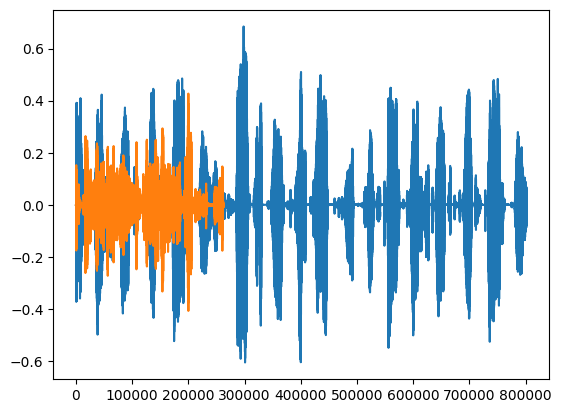

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
POS = os.path.join(path, 'cry')
NEG = os.path.join(path, 'not_cry')

In [ ]:
len(POS)

22

In [ ]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [ ]:
len(pos)

266

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [ ]:
lengths = []
for file in os.listdir(os.path.join(path, 'cry')):
    tensor_wave = load_wav_16k_mono(os.path.join(path, 'cry', file))
    lengths.append(len(tensor_wave))

In [ ]:
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=3361035>

In [ ]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

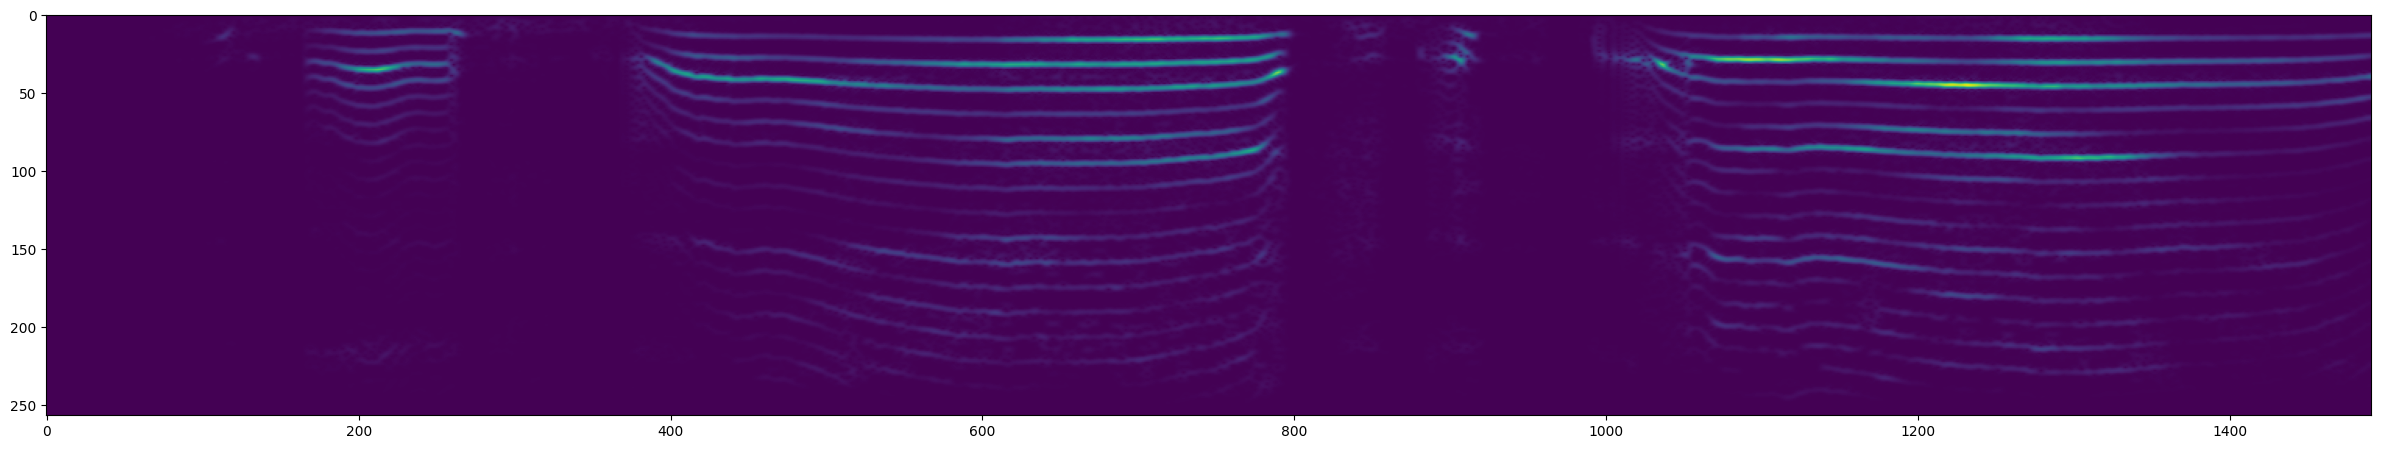

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(8)
data = data.prefetch(8)

In [ ]:
len(data)

58

In [ ]:
train = data.take(40)
test = data.skip(40).take(18)

In [ ]:
len(test)

18

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

(8, 1491, 257, 1)

In [ ]:
model = Sequential()
model.add(Conv2D(8, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 8)      80        
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 8)      584       
                                                                 
 flatten (Flatten)           (None, 3009688)           0         
                                                                 
 dense (Dense)               (None, 64)                192620096 
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 192,620,825
Trainable params: 192,620,825
Non-trainable params: 0
_________________________________________________________________


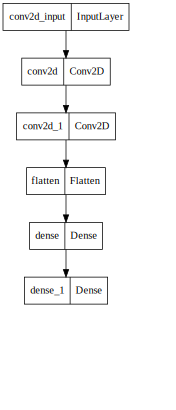

In [ ]:
SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [ ]:
hist = model.fit(train, epochs=100, validation_data=test)

Epoch 1/100
40/40 [==============================] - 16s 98ms/step - loss: 5.8177 - recall: 0.9076 - precision: 0.9382 - val_loss: 0.0061 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 2/100
40/40 [==============================] - 4s 90ms/step - loss: 0.0047 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0205 - val_recall: 1.0000 - val_precision: 0.9886
Epoch 3/100
40/40 [==============================] - 4s 88ms/step - loss: 0.0013 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.1518 - val_recall: 1.0000 - val_precision: 0.9765
Epoch 4/100
40/40 [==============================] - 3s 86ms/step - loss: 0.0710 - recall: 0.9947 - precision: 0.9947 - val_loss: 0.0047 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/100
40/40 [==============================] - 4s 95ms/step - loss: 0.0040 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0093 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 6/100
40/40 [==============================] - 3s 86ms/step - loss: 0.0052 - recall

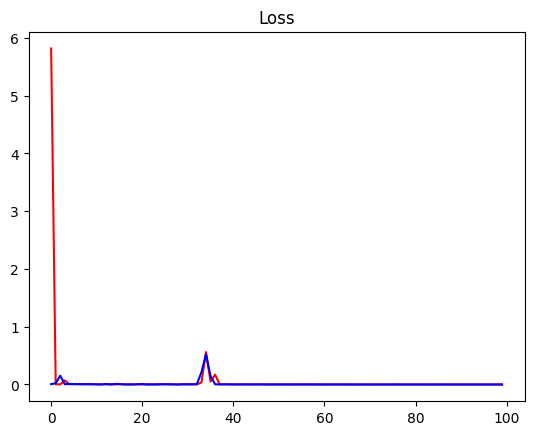

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

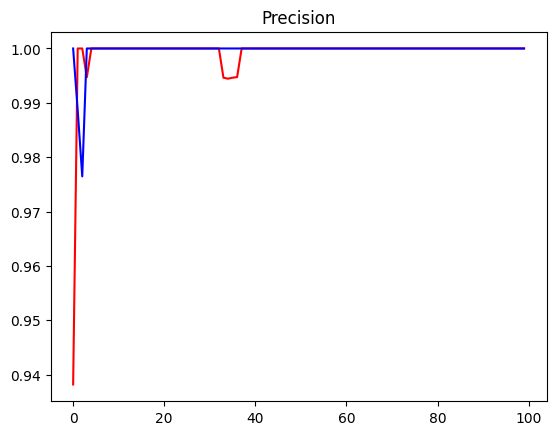

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
y_test.shape

(8,)

In [ ]:
yhat = model.predict(X_test)
yhat

1/1 [==============================] - 0s 152ms/step


array([[1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
y_hat = []
for prediction in yhat:
  if prediction > 0.5:
    y_hat.append(1)
  else:
    y_hat.append(0)

In [ ]:
y_hat

[1, 0, 1, 1, 1, 1, 1, 1]

In [ ]:
tf.math.reduce_sum(y_hat)

<tf.Tensor: shape=(), dtype=int32, numpy=7>

In [ ]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [40]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [127]:
mp3 = os.path.join(path, 'test_sample', 'merged_test.mp3')

In [128]:
wav = load_mp3_16k_mono(mp3)

In [129]:
wav

<tf.Tensor: shape=(1341431,), dtype=float32, numpy=
array([ 9.3003496e-04, -2.9140026e-03,  4.5511313e-03, ...,
       -2.2146812e+03, -3.7451702e+03, -3.6699236e+03], dtype=float32)>

In [130]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)


In [131]:
samples, index = audio_slices.as_numpy_iterator().next()

In [132]:
samples.shape

(1, 48000)

In [133]:
len(audio_slices)

27

In [134]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [135]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [136]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 [==============================] - 1s 585ms/step


In [137]:
yhat

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]